# Fitbit activity and sleep data: a time-series analysis with Generalized Additive Models

## Summary

The goal of this notebook is to provide an analysis of the time-series data from a user of a fitbit tracker throughout a year. I will use this data to predict an additional year of the life of the user using [Generalized Additive Models](https://en.wikipedia.org/wiki/Generalized_additive_model).

[Data source](https://algo-data.quora.com/Data-sets-of-any-type-some-links): [Activity](https://drive.google.com/open?id=0Bx4yoK5aogTSbGJ2WlkwYjlHejQ), [Sleep](https://drive.google.com/open?id=0Bx4yoK5aogTSMUFqRjVNcko5WlU)

Packages used:
- pandas, numpy, matplotlib, seaborn
- [Prophet](https://github.com/facebook/prophet)

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data cleaning (missing data and outliers)

In [2]:
# import the activity data
activity = pd.read_csv('OneYearFitBitData.csv')
# change commas to dots
activity.iloc[:,1:] = activity.iloc[:,1:].applymap(lambda x: float(str(x).replace(',','.')))
# change column names to English
activity.columns = ['Date', 'BurnedCalories', 'Steps', 'Distance', 'Floors', 'SedentaryMinutes', 'LightMinutes', 'ModerateMinutes', 'IntenseMinutes', 'IntenseActivityCalories']
# import the sleep data
sleep = pd.read_csv('OneYearFitBitDataSleep.csv')
# check the size of the dataframes
activity.shape, sleep.shape
# merge dataframes
data = pd.merge(activity, sleep, how='outer', on='Date')
# parse date into correct format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
# correct units for Calories and Steps
for c in ['BurnedCalories', 'Steps', 'IntenseActivityCalories']: data[c] = data[c]*1000

Once imported, we should check for any missing data:

In [4]:
# check for missing data
data.isnull().sum()

# check complete rows where sleep data is missing
data.iloc[np.where(data['MinutesOfSleep'].isnull())[0],:]

# check rows for which steps count is zero
data.iloc[np.where(data['Steps']==0)[0],:]

# drop days with a step count of zero
data = data.drop(np.where(data['Steps']==0)[0], axis=0)

,Date,BurnedCalories,Steps,Distance,Floors,SedentaryMinutes,LightMinutes,ModerateMinutes,IntenseMinutes,IntenseActivityCalories,MinutesOfSleep,MinutesOfBeingAwake,NumberOfAwakings,LengthOfRestInMinutes
0,2015-05-08,1934.0,905000.0,0.65,0.0,1.355,46.0,0.0,0.0,168000.0,NaN,NaN,NaN,NaN
275,2016-02-01,2986.0,11426.0,8.52,12.0,911.000,192.0,48.0,43.0,1478.0,NaN,NaN,NaN,NaN
276,2016-02-02,2974.0,10466.0,7.78,13.0,802.000,152.0,48.0,48.0,1333.0,NaN,NaN,NaN,NaN
277,2016-02-03,3199.0,12866.0,9.63,11.0,767.000,271.0,45.0,28.0,1703.0,NaN,NaN,NaN,NaN
278,2016-02-04,2037.0,2449.0,1.87,0.0,821.000,80.0,0.0,0.0,337000.0,NaN,NaN,NaN,NaN


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


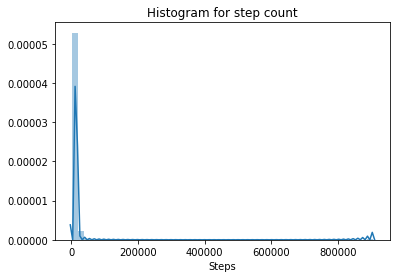

In [7]:
# plot the distribution of data for step count
sns.distplot(data['Steps'])
plt.title('Histogram for step count')

Step count is probably the most accurate measure obtained from a pedometer. Looking at the distribution of this variable, however, we can see that there is a chance that we have outliers in the data, as at least one value seems to be much higher than all the rest.

In [8]:
# sort data by step count in a descending order
data.sort_values(by='Steps', ascending=False).head()

# drop outlier
data = data.drop(np.where(data['Steps']>=100000)[0], axis=0)

,Date,BurnedCalories,Steps,Distance,Floors,SedentaryMinutes,LightMinutes,ModerateMinutes,IntenseMinutes,IntenseActivityCalories,MinutesOfSleep,MinutesOfBeingAwake,NumberOfAwakings,LengthOfRestInMinutes
0,2015-05-08,1934.0,905000.0,0.65,0.0,1.355,46.0,0.0,0.0,168000.0,NaN,NaN,NaN,NaN
267,2016-01-24,1801.0,39000.0,0.03,0.0,1.076,5.0,0.0,0.0,16000.0,342.0,48.0,31.0,390.0
42,2015-06-13,4083.0,26444.0,19.65,22.0,549.000,429.0,56.0,56.0,2818.0,169.0,20.0,11.0,196.0
363,2016-04-28,4030.0,25571.0,19.30,15.0,606.000,293.0,42.0,129.0,2711.0,374.0,56.0,34.0,430.0
320,2016-03-16,3960.0,25385.0,20.45,17.0,638.000,254.0,17.0,124.0,2556.0,368.0,46.0,22.0,414.0


In [10]:
data.shape

(369, 14)

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


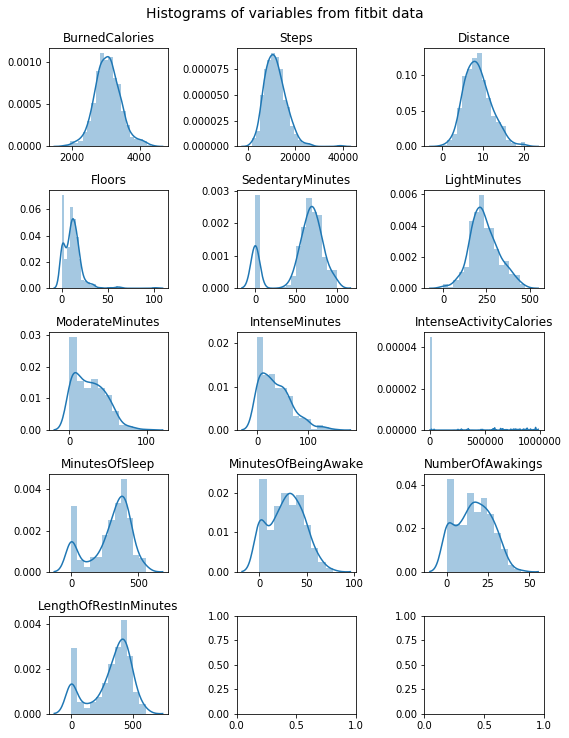

In [11]:
fig, ax = plt.subplots(5,3, figsize=(8,10))

for c, a in zip(data.columns[1:], ax.flat):
    df = pd.DataFrame()
    df['ds'] = data['Date']
    df['y'] = data[c]
    df = df.dropna(axis=0, how='any')
    sns.distplot(df['y'], axlabel=False, ax=a)
    a.set_title(c)

plt.suptitle('Histograms of variables from fitbit data', y=1.02, fontsize=14);
plt.tight_layout()

## Predicting the step count for an additional year

In order to use the Prophet package to predict the future using a Generalized Additive Model, we need to create a dataframe with columns ```ds``` and ```y``` (we need to do this for each variable):
- ```ds``` is the date stamp data giving the time component
- ```y``` is the variable that we want to predict

In our case we will use the log transform of the step count in order to decrease the effect of outliers on the model.

In [13]:
df = pd.DataFrame()
df['ds'] = data['Date']
df['y'] = data['Steps']
# log-transform of step count
df['y'] = np.log(df['y'])

Now we need to specify the type of growth model that we want to use:
- Linear: assumes that the variable ```y``` grows linearly in time (doesn't apply to our step count scenario, if the person sticks to their normal lifestyle)
- Logistic: assumes that the variable ```y``` grows logistically in time and saturates at some point

I will assume that the person, for whom we want to predict the step count in the following year, will not have any dramatic lifestyle changes that makes them start to walk more. Therefore, I am using logistic 'growth' capped to a cap of the mean of the data, which in practice means that the step count's growth trend will be 'zero growth'.

In [14]:
df['cap'] = df['y'].median()
m = Prophet(growth='logistic', yearly_seasonality=True)
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


After fitting the model, we need a new dataframe ```future``` with the additional rows for which we want to predict ```y```.

In [15]:
future = m.make_future_dataframe(periods=30, freq='D')
future['cap'] = df['y'].median()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

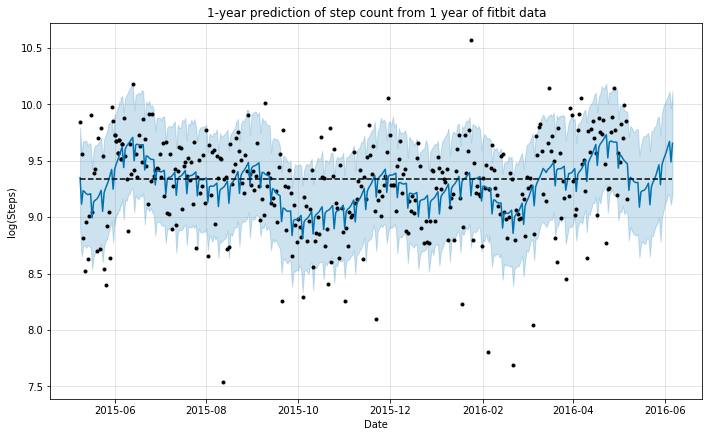

In [17]:
m.plot(forecast, ylabel='log(Steps)', xlabel='Date');
plt.title('1-year prediction of step count from 1 year of fitbit data');

We can see that the model did a good job in mimicking the behavior of step count during the year for which the data was available. This seems reasonable, as we do not expect the pattern to vary necessarily, if the person continues to have a similar lifestyle.

Additionally, we can plot the components from the Generalized Additive Model and see their effect on the 'y' variable. In this case we have the general trend (remember we capped this at '10'), the yearly seasonality effect, and the weekly effect.

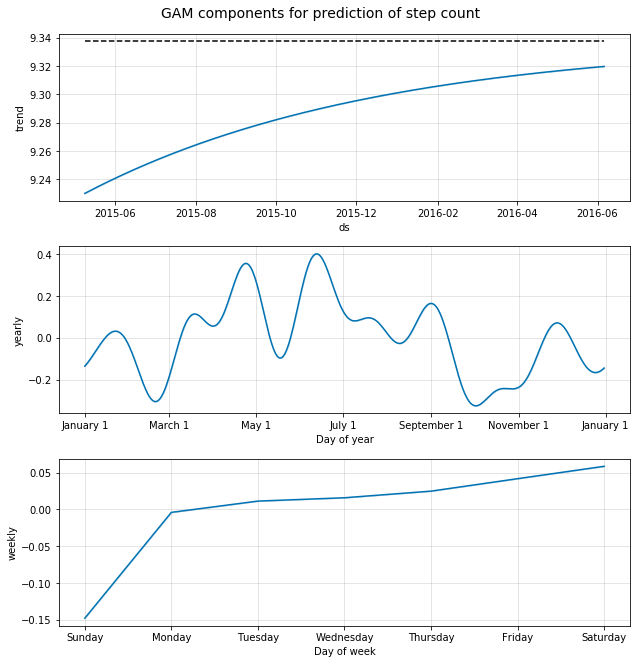

In [18]:
m.plot_components(forecast);
plt.suptitle('GAM components for prediction of step count', y=1.02, fontsize=14);

Here we see some interesting patterns:
- The general 'growth' trend is as expected, as we assumed that there would be no growth beyond the mean of the existing data.
- The yearly effect shows a trend towards higher activity during the summer months, however the variation is considerable, probably due to the fact that our dataset consisted of the data for one year only
- The weekly effect shows that Sunday is a day of lower activity for this person whereas Saturday is the day where the activity is the highest. So, grocery shopping on Saturday, Netflix on Sunday? :)

## Sleep analysis

A very important part of our lives is sleep. It would be very interesting to look at the sleep habits of the user of the fitness tracker and see if we can get some insights from this data.

In [19]:
df = pd.DataFrame()
df['ds'] = data['Date']
df['y'] = data['MinutesOfSleep']
df = df.dropna(axis=0, how='any')
# drop rows where sleep time is zero, as this would mean that the person did not wear the tracker overnight and the data is missing
df = df.iloc[np.where(df['y']!=0)[0],:]

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


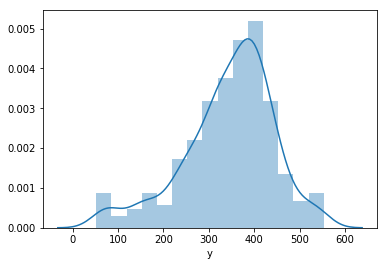

In [20]:
# distribution of MinutesOfSleep
sns.distplot(df['y'])

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


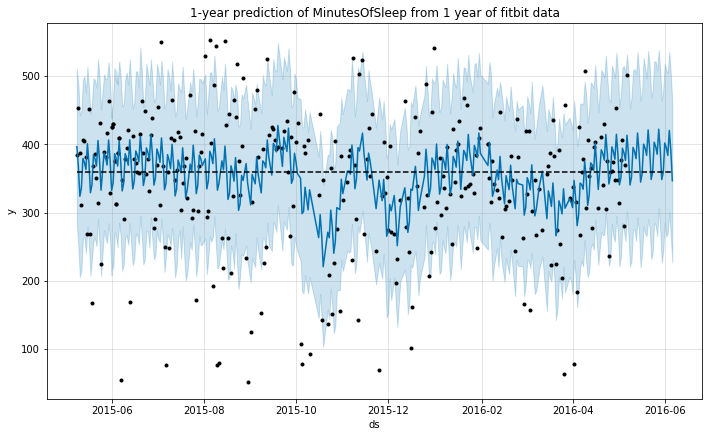

In [21]:
df['cap'] = df['y'].median()
m = Prophet(growth='logistic', yearly_seasonality=True)
m.fit(df)

future = m.make_future_dataframe(periods=30, freq='D')
future['cap'] = df['y'].median()

forecast = m.predict(future)
m.plot(forecast);
plt.title('1-year prediction of MinutesOfSleep from 1 year of fitbit data');

The model again seems to predict a similar sleep behavior for the predicted year. This seems reasonable, as we do not expect the pattern to vary necessarily, if the person continues to have a similar lifestyle.

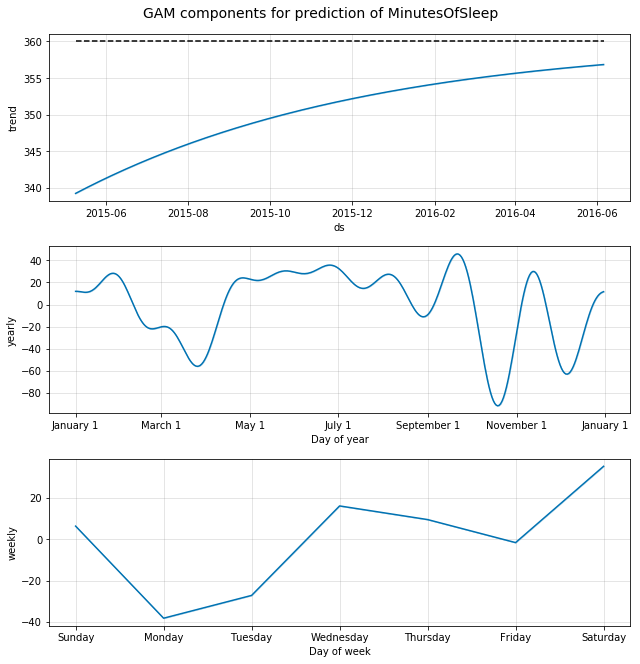

In [22]:
m.plot_components(forecast);
plt.suptitle('GAM components for prediction of MinutesOfSleep', y=1.02, fontsize=14);

A look at the amount of sleep reveals:
- A saturation trend at the median (we set this assumption)
- A yearly effect shows a trend towards higher amount of sleep during the summer months, with more variation during winter
- The weekly effect shows lowest sleep amount on Mondays (maybe going to bed late on Sunday and waking up early on Monday is a pattern for this user). Highest amout of sleep occurs on Saturdays (no alarm to wake up to on Saturday morning!). Interestingly, the user seems to get more sleep on Wednesdays than on Mondays or Tuesdays, which could mean that their work schedule is not constant during week-days.

### Appendix
As an exercise, I have plotted the predictions for the most interesing variables in the dataset. Enjoy!

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

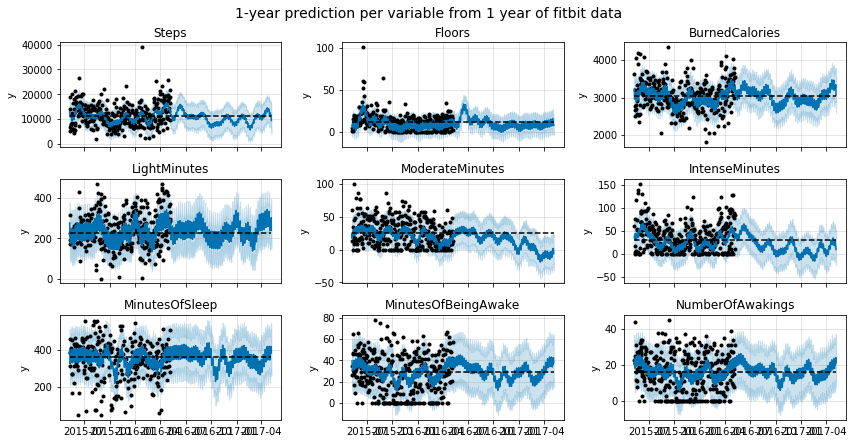

In [23]:
zeros_allowed = ['Floors', 'SedentaryMinutes', 'LightMinutes', 'ModerateMinutes', 'IntenseMinutes', 'IntenseActivityCalories', 'MinutesOfBeingAwake', 'NumberOfAwakings']

fig, ax = plt.subplots(3,3, figsize=(12,6), sharex=True)

predict_cols = ['Steps', 'Floors', 'BurnedCalories', 'LightMinutes', 'ModerateMinutes', 'IntenseMinutes', 'MinutesOfSleep', 'MinutesOfBeingAwake', 'NumberOfAwakings']

for c, a in zip(predict_cols, ax.flat):
    df = pd.DataFrame()
    df['ds'] = data['Date']
    df['y'] = data[c]
    df = df.dropna(axis=0, how='any')
    
    if c not in zeros_allowed:
        df = df.iloc[np.where(df['y']!=0)[0],:]

    df['cap'] = df['y'].median()
    m = Prophet(growth='logistic', yearly_seasonality=True)
    m.fit(df)

    future = m.make_future_dataframe(periods=365, freq='D')
    future['cap'] = df['y'].median()
    future.tail()

    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    m.plot(forecast, xlabel='', ax=a);
    a.set_title(c)

    #m.plot_components(forecast);

plt.suptitle('1-year prediction per variable from 1 year of fitbit data', y=1.02, fontsize=14);
plt.tight_layout()